# Agentic Retrieval Augmented Generation with LangGraph

## Setup

In [2]:
import os, json, re, getpass
from dotenv import load_dotenv

load_dotenv(override=True)

True

In [3]:
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

In [4]:
#Check for Groq API Key
_set_env("GROQ_API_KEY")

In [5]:
#Check for Tavily API Key
_set_env("TAVILY_API_KEY")

In [6]:
#Check for OpenAI API Key
_set_env("OPENAI_API_KEY")

### Libraries

In [7]:
#Basic Imports
import os, json, re, getpass, warnings, time
from dotenv import load_dotenv
from IPython.display import display, Markdown
from pprint import pprint
from uuid import uuid4

#LangChain libraries
from langchain.chat_models import init_chat_model
from langchain_ollama import OllamaEmbeddings
from langchain_chroma import Chroma
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.prompts import ChatPromptTemplate
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from langchain_tavily import TavilySearch
from langchain.schema import Document

#Other libraries
import numpy as np
from typing import Literal, List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

USER_AGENT environment variable not set, consider setting it to identify your requests.


## Defining Components

### Chat Model

**Benefits** of using 2 LLMs, one to generate (final generation and question re-writing) and another for grading tasks, are 

1) lower cost
2) smaller latency
3) handling rate limits

In [80]:
model_name_generate = "gpt-4o-mini"
llm_generate = init_chat_model(model_name_generate, model_provider="openai") #Other Llama alternatives available are llama3-8b-8192, llama-3.3-70b-versatile

In [81]:
model_name_eval = model_name_generate
# model_name_eval = "llama-3.1-8b-instant"
llm_eval = llm_generate 
# llm_eval = init_chat_model(model_name_eval, model_provider="groq") #Other Llama alternatives available are llama3-8b-8192, llama-3.3-70b-versatile

### Embedding Model

In [10]:
!ollama pull llama3.1:8b

pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠸ pulling manifest ⠼ pulling manifest ⠴ pulling manifest ⠦ pulling manifest ⠧ pulling manifest ⠇ pulling manifest ⠏ pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠸ pulling manifest 
pulling 667b0c1932bc: 100% ▕██████████████████▏ 4.9 GB                         
pulling 948af2743fc7: 100% ▕██████████████████▏ 1.5 KB                         
pulling 0ba8f0e314b4: 100% ▕██████████████████▏  12 KB                         
pulling 56bb8bd477a5: 100% ▕██████████████████▏   96 B                         
pulling 455f34728c9b: 100% ▕██████████████████▏  487 B                         
verifying sha256 digest 
writing manifest 
success 


In [11]:
embeddings_model = OllamaEmbeddings(model="llama3.1:8b")

### Vector Store

In [12]:
#Create a vector store
vectorstore = Chroma(
    collection_name="agentic_rag_with_langgraph",
    embedding_function=embeddings_model,
    # persist_directory="./chroma_langchain_db",  # Where to save data locally, remove if not necessary
)

## Retriever

First, we index 3 pages.

In [13]:
urls = [
    "https://www.truefoundry.com/",
    "https://www.truefoundry.com/ai-gateway",
    "https://www.truefoundry.com/solutions/aimlleaders"
]

In [14]:
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

In [15]:
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=100, chunk_overlap=50
)
doc_splits = text_splitter.split_documents(docs_list)

In [16]:
# Store in Chroma only first 20 docs
top_docs = 20 #Number of docs 
uuids = [str(uuid4()) for _ in range(len(doc_splits))] #Universally unique identifier
vectorstore.add_documents(documents = doc_splits[:top_docs], ids = uuids[:top_docs]) #Add documents

['55bdb2d6-8ef3-45ac-89fe-0988fc618eb3',
 '77dfdc9c-b623-4b9f-b4ea-88de14ff93d1',
 '95796ab9-e1ec-4509-9ef6-daa8ea42b2a1',
 'df97aea9-ef58-4f5b-9323-43bad84fed4b',
 'e5a2688d-850d-44cc-bacf-a0b9bdac094e',
 '593c72c4-6ac3-46e4-94eb-969d341686fc',
 '7b8fb886-75bc-4170-a9cd-640e75e91c47',
 'e1a04cb6-4488-49b3-b52e-e69534d8b9ec',
 '3338aae4-2da7-4e0e-a5c6-892aa71a2644',
 'ed51a23f-00b8-4428-aace-5ecf3ccb167f',
 'cf6669fe-3c86-4e26-8e78-4a70ebc71b40',
 'cc4a8ac0-2fd3-458b-bf5b-23a49c55c39d',
 'c778778a-4870-4393-91c2-023ae6bd0d02',
 '31f46576-6b40-4f8d-a717-0273f041f1a2',
 'd30849d6-aa44-49a2-9b41-65a2e07b3522',
 '0cd8155b-3c0d-4098-97ad-077a38ede5d6',
 '0759fe9b-1406-4d3d-b03d-aa113c50e85b',
 'ba14068e-5ace-4fea-b853-a6dc10966b10',
 '92e6ad89-2387-4230-8dc0-35b5d8bf307a',
 '13e26c13-5eec-4b26-8d38-fe92f09b8be5']

In [17]:
retriever = vectorstore.as_retriever(search_type="mmr")

## Define Test Questions

In [18]:
question_search = "Who won the Indian Premier League 2025?"

In [19]:
question_doc = "What is TrueFoundry AI Gateway?"

## LLMs

### Router

In [20]:
# Data model
class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasource."""

    datasource: Literal["vectorstore", "web_search"] = Field(
        ...,
        description="Given a user question choose to route it to web search or a vectorstore.",
    )

In [21]:
# LLM with function call
structured_llm_router = llm_eval.with_structured_output(RouteQuery)

In [22]:
# Prompt
system = """You are an expert at routing a user question to a vectorstore or web search.
The vectorstore contains documents related to PGP program in AI and Data Science at Jio Institute.
Use the vectorstore for questions on these topics. Otherwise, use web-search."""
route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

In [23]:
question_router = route_prompt | structured_llm_router
print(
    question_router.invoke(
        {"question": question_search}
    )
)
print(question_router.invoke({"question": question_doc}))

datasource='web_search'
datasource='web_search'


### Retrieval Grader

In [83]:
# Data model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )

In [84]:
# LLM with function call
structured_llm_grader = llm_eval.with_structured_output(GradeDocuments)

In [85]:
# Prompt
system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

In [86]:
retrieval_grader = grade_prompt | structured_llm_grader
docs = retriever.invoke(question_doc)
print(retrieval_grader.invoke({"question": question_doc, "document": docs}))

binary_score='yes'


### Generate

In [30]:
# Prompt
prompt = hub.pull("rlm/rag-prompt")

In [31]:
# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

In [32]:
# Chain
rag_chain = prompt | llm_generate | StrOutputParser()

In [33]:
# Run
generation = rag_chain.invoke({"context": docs, "question": question_doc})
print(generation)

TrueFoundry AI Gateway is a low-latency component of the TrueFoundry platform, which is a Kubernetes-native infrastructure designed for executing agentic AI workloads. It facilitates tasks such as LLM inference, fine-tuning, and classic ML serving, with a focus on scalability and seamless integration across cloud and on-premises environments. The platform also includes enterprise-grade security, governance, and cost controls.


### Hallucination Grader

In [34]:
# Data model
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: str = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )

In [35]:
# LLM with function call
structured_llm_grader = llm_eval.with_structured_output(GradeHallucinations)

In [36]:
# Prompt
system = """You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts. \n 
     Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts."""
hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
    ]
)

In [37]:
hallucination_grader = hallucination_prompt | structured_llm_grader
hallucination_grader.invoke({"documents": docs, "generation": generation})

GradeHallucinations(binary_score='yes')

In [38]:
generation

'TrueFoundry AI Gateway is a low-latency component of the TrueFoundry platform, which is a Kubernetes-native infrastructure designed for executing agentic AI workloads. It facilitates tasks such as LLM inference, fine-tuning, and classic ML serving, with a focus on scalability and seamless integration across cloud and on-premises environments. The platform also includes enterprise-grade security, governance, and cost controls.'

### Answer Grader

In [39]:
# Data model
class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""

    binary_score: str = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )

In [40]:
# LLM with function call
structured_llm_grader = llm_eval.with_structured_output(GradeAnswer)

In [41]:
# Prompt
system = """You are a grader assessing whether an answer addresses / resolves a question \n 
     Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question."""
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)

In [42]:
answer_grader = answer_prompt | structured_llm_grader
answer_grader.invoke({"question": question_doc, "generation": generation})

GradeAnswer(binary_score='no')

In [43]:
print(question_doc, "\n\n", generation)

What is TrueFoundry AI Gateway? 

 TrueFoundry AI Gateway is a low-latency component of the TrueFoundry platform, which is a Kubernetes-native infrastructure designed for executing agentic AI workloads. It facilitates tasks such as LLM inference, fine-tuning, and classic ML serving, with a focus on scalability and seamless integration across cloud and on-premises environments. The platform also includes enterprise-grade security, governance, and cost controls.


### Question Re-writer

In [44]:
# Prompt
system = """You are a question re-writer that converts an input question to a better version that is optimized \n 
     for vectorstore retrieval. Look at the input and try to reason about the underlying semantic intent / meaning. \n 
     Only return the rewritten question and nothing else."""
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

In [45]:
question_doc

'What is TrueFoundry AI Gateway?'

In [46]:
question_rewriter = re_write_prompt | llm_generate | StrOutputParser()
question_rewriter.invoke({"question": question_doc})

'What are the features and functionalities of TrueFoundry AI Gateway?'

## Tools

### Search Tool

In [47]:
web_search_tool = TavilySearch(max_results=10)

## Construct the Graph 

Capture the flow in as a graph.

### Define Graph State

We will define a graph.

A `state` object that it passes around to each node.

Our state will have 3 attributes - `question`, `generation` and `documents`.

Each node in our graph will update to it.

In [48]:
class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """

    question: str
    generation: str
    documents: List[str]

### Define Graph Flow 

We can lay out an agentic RAG graph like this:

* The state has a set of attributes
* Each node will update the state
* Conditional edges decide which node to visit next

#### Nodes

In [49]:
def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents}

In [50]:
def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"generation": generation}

In [51]:
def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    return {"documents": filtered_docs}

In [52]:
def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"question": better_question}

In [53]:
def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---WEB SEARCH---")
    question = state["question"]

    # Web search
    searched_docs = web_search_tool.invoke({"query": question})
    # print(searched_docs) ## for debugging only
    # web_results = "\n".join([d["content"] if searched_docs["results"] else searched_docs for d in searched_docs["results"]]) ## incase search doesn't return anything
    web_results = "\n".join([d["content"] for d in searched_docs["results"]])
    web_results = Document(page_content=web_results)

    #Condition for Adaptive RAG, that has a flow of web search without a retrieval step first
    if "documents" in state.keys():
        documents = state["documents"]
        documents.append(web_results)
        return {"documents": documents}
    
    else:
        return {"documents": web_results}

#### Edges

In [54]:
def route_question(state):
    """
    Route question to web search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["question"]
    source = question_router.invoke({"question": question})
    # return source.datasource
    
    if source.datasource == "web_search":
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "web_search"
    elif source.datasource == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"

In [55]:
def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    state["question"]
    filtered_documents = state["documents"]

    if not filtered_documents:
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"

In [56]:
def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    grade = score.binary_score

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score.binary_score
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        else:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
    else:
        pprint("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"

### Compile Graph

All these flows are different kinds of **Self-Reflective RAG**, and Adaptive RAG has an additional flow of **Query Analysis**.

#### Flow 1 - Corrective RAG

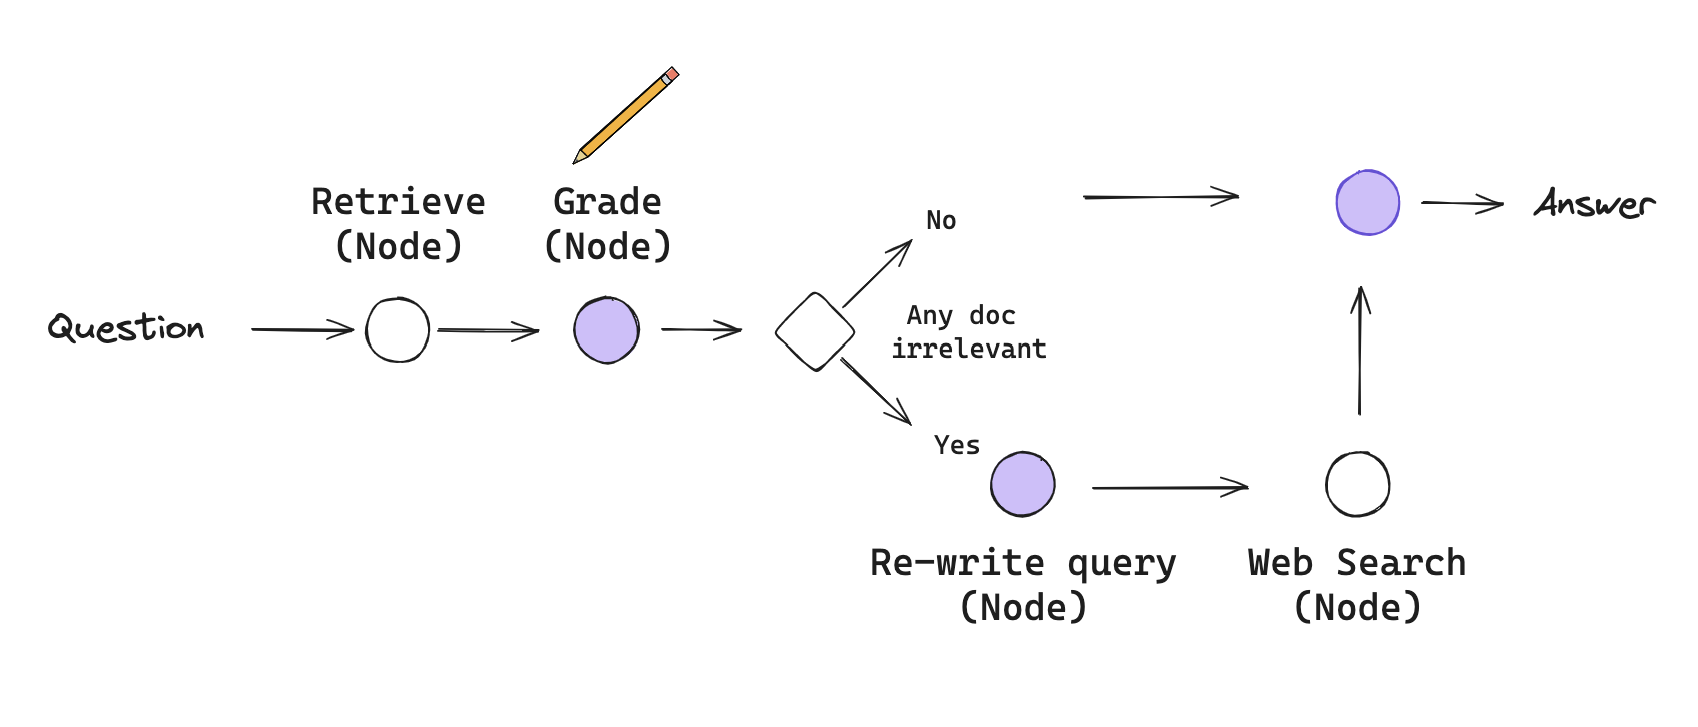
[Reference here](https://langchain-ai.github.io/langgraph/tutorials/rag/langgraph_crag/)

In [57]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("transform_query", transform_query)  # transform_query
workflow.add_node("web_search", web_search)  # web search

# Build graph
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "web_search")
workflow.add_edge("web_search", "generate")
workflow.add_edge("generate", END)

# Compile
graph_1_crag = workflow.compile()

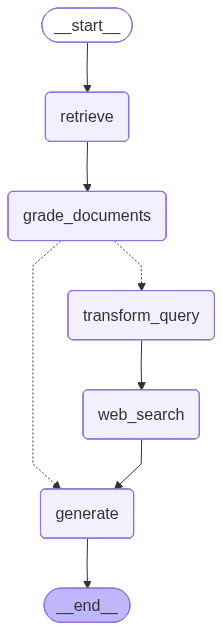

In [58]:
from IPython.display import Image, display

try:
    display(Image(graph_1_crag.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

#### Flow 2 - Self-RAG

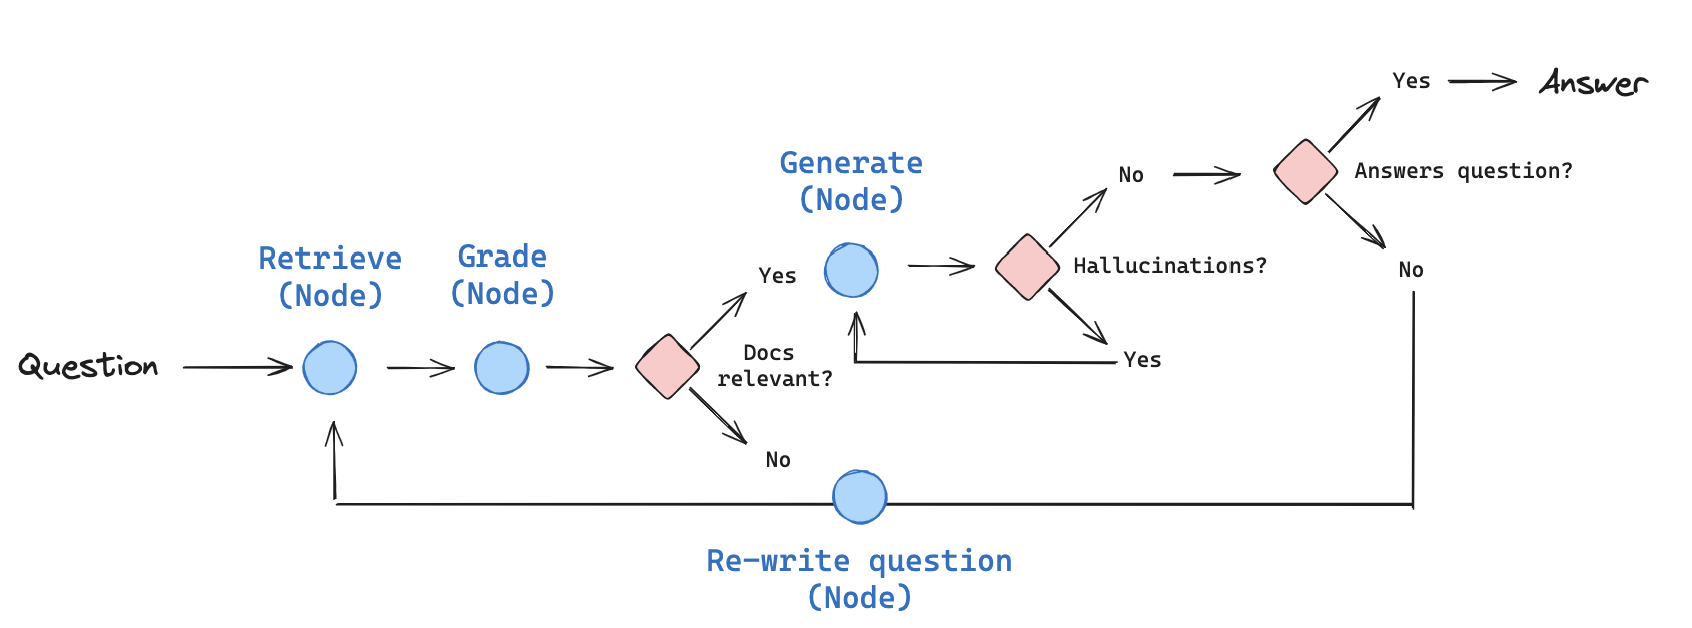
[Reference here](https://langchain-ai.github.io/langgraph/tutorials/rag/langgraph_self_rag/)

In [59]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("transform_query", transform_query)  # transform_query

# Build graph
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "retrieve")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "transform_query",
    },
)

# Compile
graph_2_selfrag = workflow.compile()

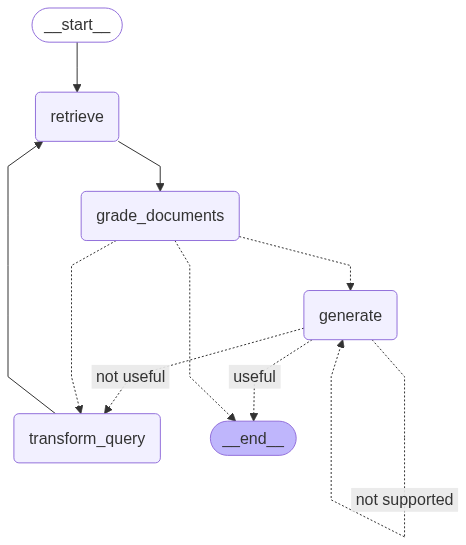

In [60]:
from IPython.display import Image, display

try:
    display(Image(graph_2_selfrag.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

#### Flow 3 - Corrective RAG (custom) = Corrective RAG + Hallucination + Answer Relevance Checker

In [61]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("transform_query", transform_query)  # transform_query
workflow.add_node("web_search", web_search)  # web search

# Build graph
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "web_search")
workflow.add_edge("web_search", "generate")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "transform_query",
    },
)

# Compile
graph_3_crag_custom = workflow.compile()

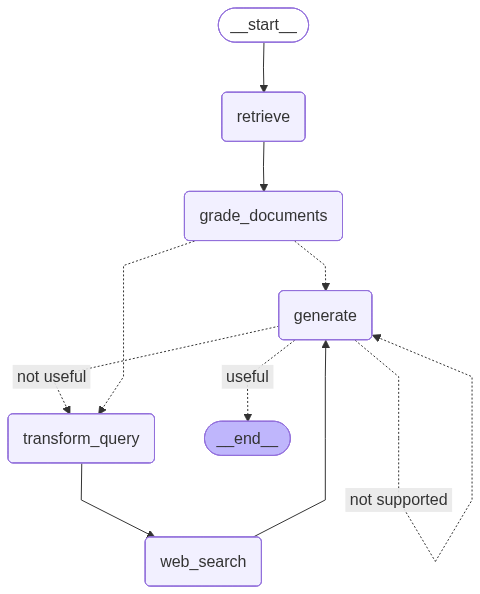

In [62]:
from IPython.display import Image, display

try:
    display(Image(graph_3_crag_custom.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

#### Flow 4 - Adaptive RAG = Self-RAG + Query Analysis

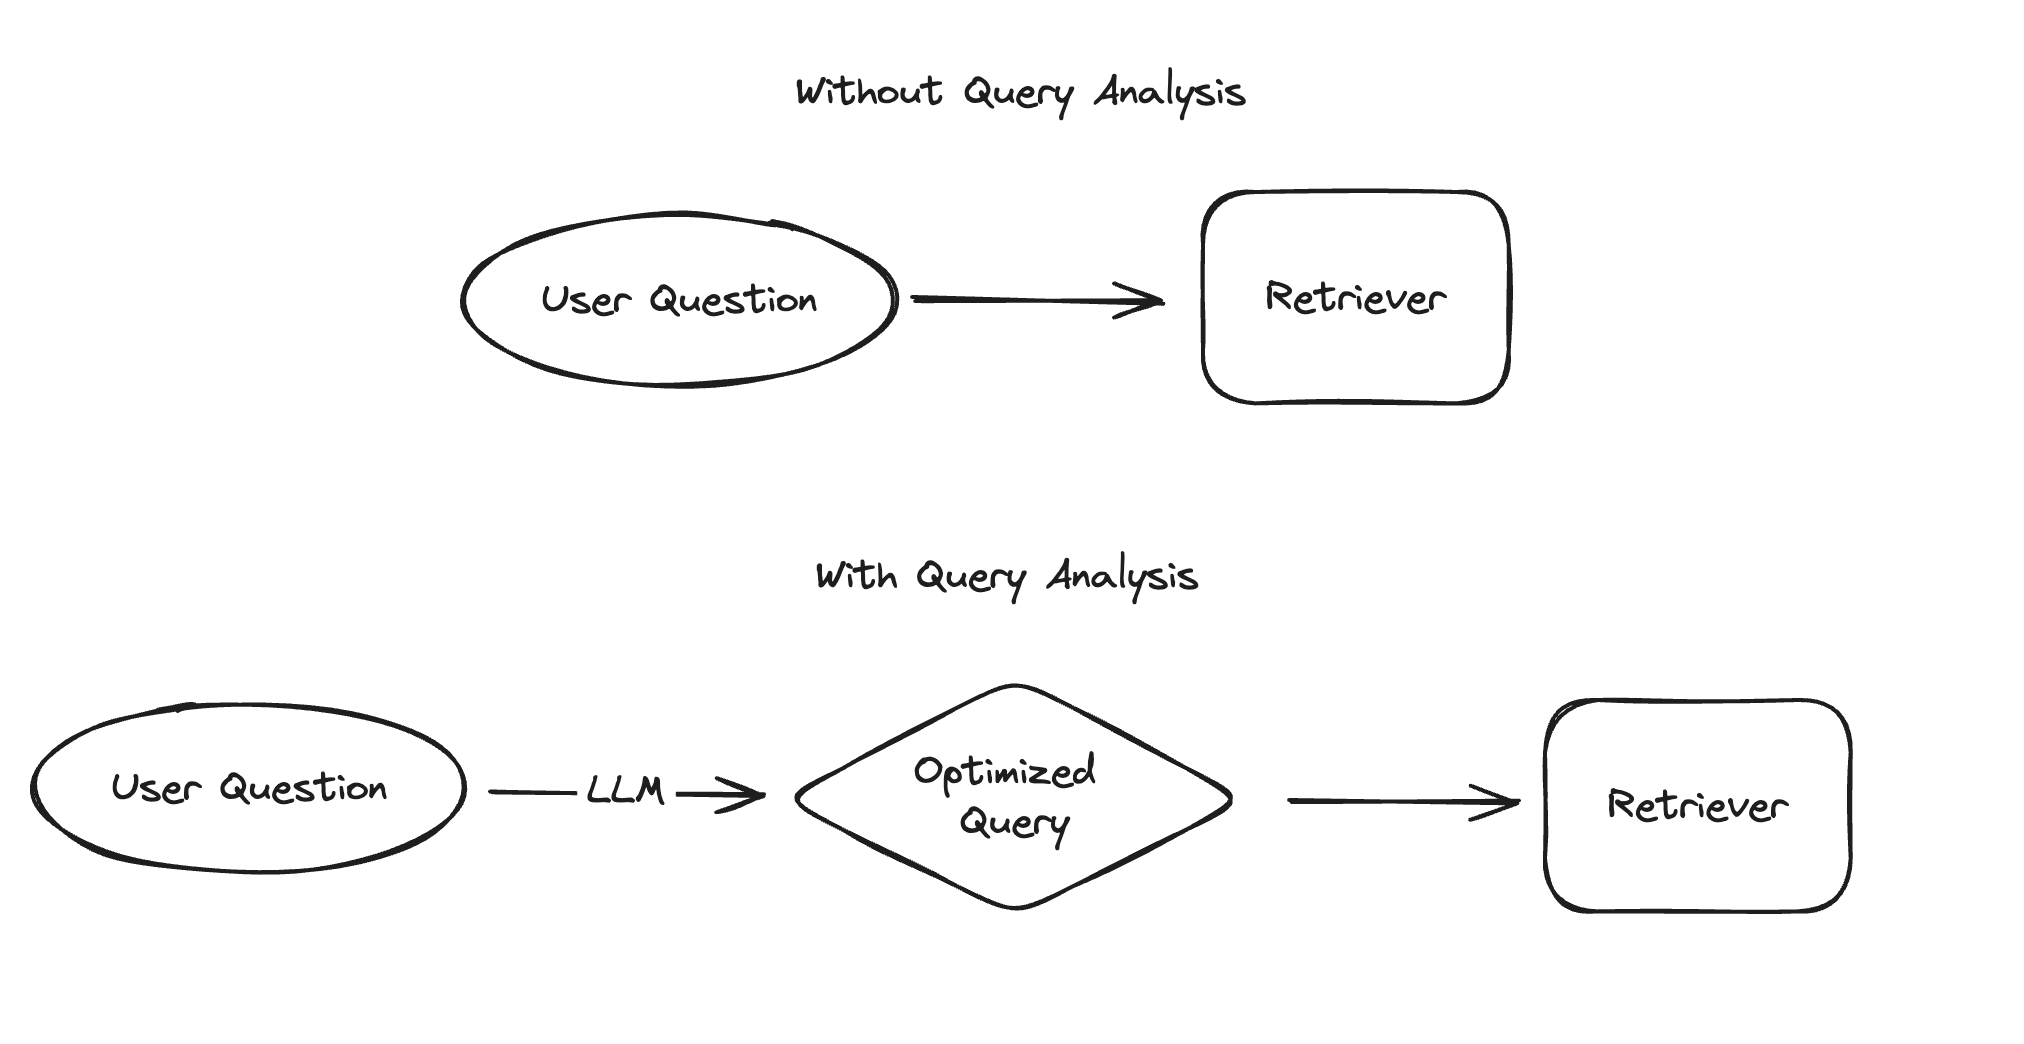
[Reference here](https://python.langchain.com/v0.1/docs/use_cases/query_analysis/)

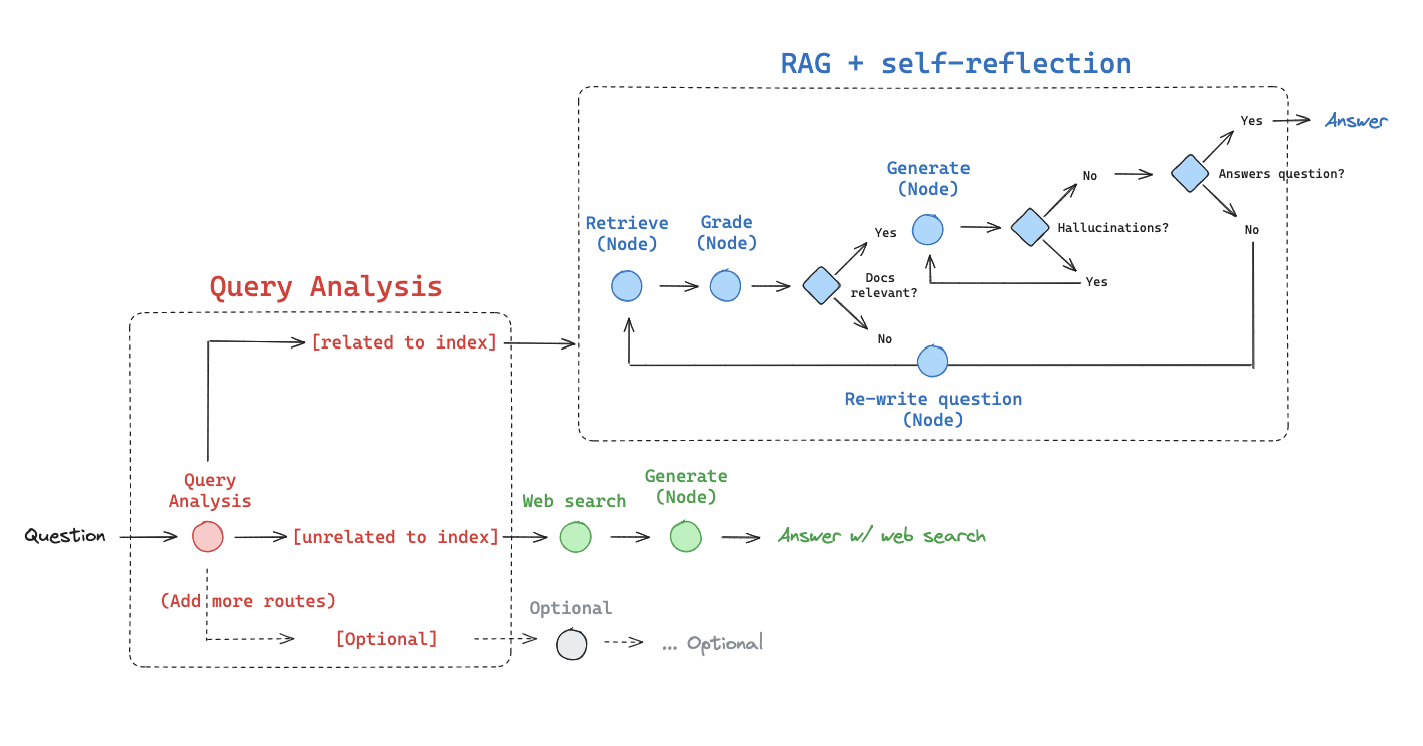
[Reference here](https://langchain-ai.github.io/langgraph/tutorials/rag/langgraph_adaptive_rag/)

In [63]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("web_search", web_search)  # web search
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("transform_query", transform_query)  # transform_query

# Build graph
# set_conditional_entry_point method doesn't require mentioning START
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "web_search": "web_search",
        "vectorstore": "retrieve",
    },
)
workflow.add_edge("web_search", "generate")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "retrieve")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "transform_query",
    },
)

# Compile
graph_4_adaptiverag = workflow.compile()

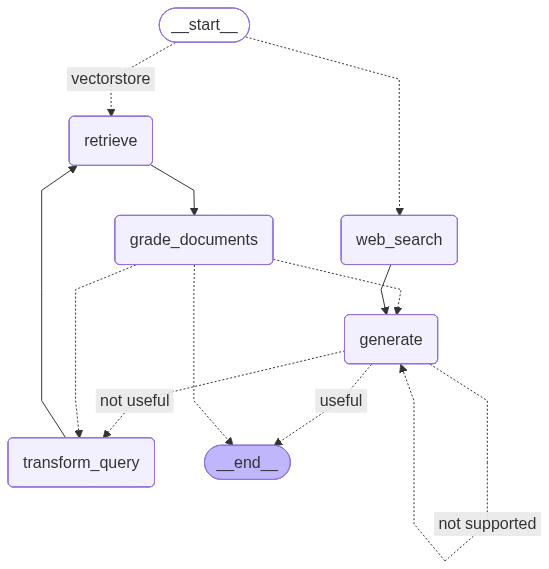

In [64]:
from IPython.display import Image, display

try:
    display(Image(graph_4_adaptiverag.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

#### Flow 5 - Adaptive RAG (custom) = Corrective RAG (custom) + Query Analysis

In [65]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("transform_query", transform_query)  # transform_query
workflow.add_node("web_search", web_search)  # web search

# Build graph
# set_conditional_entry_point method doesn't require mentioning START
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "web_search": "web_search",
        "vectorstore": "retrieve",
    },
)
workflow.add_edge("web_search", "generate")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "web_search")
workflow.add_edge("web_search", "generate")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "transform_query",
    },
)

# Compile
graph_5_adaptiverag_custom = workflow.compile()

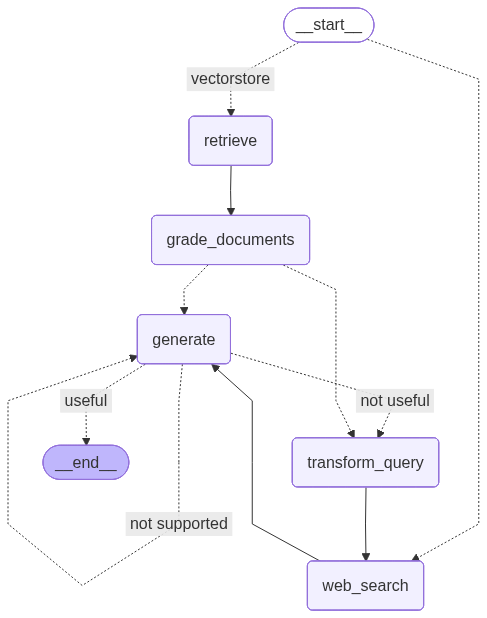

In [66]:
from IPython.display import Image, display

try:
    display(Image(graph_5_adaptiverag_custom.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

## Use Graph

### For Question Not in Context

In [67]:
question_search

'Who won the Indian Premier League 2025?'

In [68]:
# Run
inputs = {
    "question": question_search
}

In [87]:
#Self-RAG gets stuck in loop!
for i,app in enumerate([graph_1_crag, graph_3_crag_custom, graph_5_adaptiverag_custom]):
    print("FLOW {}----->".format(str(2*i+1))+"\n")
    for output in app.stream(inputs):
        for key, value in output.items():
            # Node
            pprint(f"Node '{key}':")
            # Optional: print full state at each node
            # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
        pprint("\n---\n")
    
    # Final generation
    pprint(value["generation"])
    print("---"*20 + "\n\n\n")
    time.sleep(20) ## to avoid rate limits

FLOW 1----->

---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---
"Node 'grade_documents':"
'\n---\n'
---TRANSFORM QUERY---
"Node 'transform_query':"
'\n---\n'
---WEB SEARCH---
"Node 'web_search':"
'\n---\n'
---GENERATE---
"Node 'generate':"
'\n---\n'
('The winner of the Indian Premier League in 2025 was the Royal Challengers '
 'Bengaluru (RCB). They defeated the Punjab Kings in the final by 6 runs, '
 'securing their maiden IPL trophy. Virat Kohli expressed immense joy after '
 'this long-awaited victory for the team.')
------------------------------------------------------------



FLOW 3----->

---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT REL

### For Question in Context

In [88]:
question_doc

'What is TrueFoundry AI Gateway?'

In [89]:
# Run
inputs = {"question": question_doc}

In [91]:
for i,app in enumerate([graph_1_crag, graph_2_selfrag, graph_3_crag_custom]):
    print("FLOW {}----->".format(str(i+1))+"\n")
    for output in app.stream(inputs):
        for key, value in output.items():
            # Node
            pprint(f"Node '{key}':")
            # Optional: print full state at each node
            # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
        pprint("\n---\n")
    
    # Final generation
    pprint(value["generation"])
    print("---"*20 + "\n\n\n")
    time.sleep(20) ## to avoid rate limits

FLOW 1----->

---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---
"Node 'grade_documents':"
'\n---\n'
---TRANSFORM QUERY---
"Node 'transform_query':"
'\n---\n'
---WEB SEARCH---
"Node 'web_search':"
'\n---\n'
---GENERATE---
"Node 'generate':"
'\n---\n'
('TrueFoundry AI Gateway offers a unified interface for accessing over 1000 '
 'LLMs with features such as enterprise-grade security, observability, rate '
 'limiting, and governance. It allows for both SaaS and on-premise '
 'deployments, providing control over AI operations and easy integration '
 'without requiring changes to existing code. The gateway also supports '
 'traffic control, access management, and real-time monitoring capabilities '
 'tailored for 

In [93]:
#Adaptive RAG (custom) is referring to web search, although information is present in the provided context
for i,app in enumerate([graph_4_adaptiverag, graph_5_adaptiverag_custom]):
    print("FLOW {}----->".format(str(i+4))+"\n")
    for output in app.stream(inputs):
        for key, value in output.items():
            # Node
            pprint(f"Node '{key}':")
            # Optional: print full state at each node
            # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
        pprint("\n---\n")
    
    # Final generation
    pprint(value["generation"])
    print("---"*20 + "\n\n\n")
    time.sleep(20) ## to avoid rate limits

FLOW 4----->

---ROUTE QUESTION---
---ROUTE QUESTION TO WEB SEARCH---
---WEB SEARCH---
"Node 'web_search':"
'\n---\n'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
"Node 'generate':"
'\n---\n'
('TrueFoundry AI Gateway is a unified interface that provides access to over '
 '1000 large language models (LLMs) while ensuring enterprise-grade security, '
 'observability, and governance. It serves as a proxy layer between '
 'applications and LLM providers, allowing organizations to deploy and manage '
 'their own Model Control Protocol (MCP) servers with ease. The gateway can be '
 'used as a SaaS solution or deployed on-premise, offering complete control '
 'over AI operations.')
------------------------------------------------------------



FLOW 5----->

---ROUTE QUESTION---
---ROUTE QUESTION TO WEB SEARCH---
---WEB SEARCH---
"Node 'web_search':"
'\n---\n'
---G